In [18]:
from pathlib import Path
import pickle

import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import pad
from tqdm.auto import tqdm

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(str(Path(".").resolve().parent.parent))

from berp.datasets import BerpDataset, NestedBerpDataset

In [53]:
story_name = "old-man-and-the-sea"
subject = 1
run = 2

aligned_words = "word.csv"
aligned_phonemes = "phoneme.csv"

stimulus = "old-man-and-the-sea/run2.pkl"

# run_Xy = "../../workflow/heilbron2022/data/run_Xy/old-man-and-the-sea/sub1/run1.h5"
run_Xy = "/home/jgauthie/om2/others/heilbron2022/notebooks/exported/Xy/words_proba/sub1/run2.h5"

target_sample_rate = 128
output_path = "old-man-and-the-sea.sub1.run2.pkl"

## Load and process natural language stimulus

In [54]:
with Path(stimulus).open("rb") as f:
    story_stim = pickle.load(f)
    
assert story_stim.name == f"{story_name}/run{run}"

In [55]:
# Variable onset features are simply a variable onset intercept,
# word features and word surprisals.
X_variable = torch.concat(
    [torch.ones_like(story_stim.word_surprisals).unsqueeze(1),
     story_stim.word_features,
     story_stim.word_surprisals.unsqueeze(1)],
    dim=1)
variable_feature_names = ["recognition_onset"] + story_stim.word_feature_names + ["word_surprisal"]

assert X_variable.shape[1] == len(variable_feature_names)

In [212]:
variable_feature_names

['recognition_onset', 'word_frequency', 'word_surprisal']

## Load design matrix data

In [110]:
with h5py.File(run_Xy) as f:
    assert subject == f.attrs["subject"]
    assert run == f.attrs["run"]
    
    X = f["X"][()]
    y = f["y"][()].T
    
    sensor_names = f.attrs["ch_names"].tolist()
    ts_feature_names = f.attrs["feature_names"].tolist()
    sfreq = f.attrs["sfreq"]

In [111]:
assert X.shape[0] == y.shape[0]
assert X.shape[1] == len(ts_feature_names)
assert y.shape[1] == len(sensor_names)

### Add intercept feature to time series

X = np.hstack([np.ones((X.shape[0], 1)), X])
ts_feature_names = ['intercept'] + ts_feature_names

### Remove surprisal+frequency data

In [211]:
drop_ts_features = ["all_words_lexical_surprise", "all_words_unigram_surprise"]
keep_ts_feature_idxs = [i for i, name in enumerate(ts_feature_names) if name not in drop_ts_features]

X = X[:, keep_ts_feature_idxs]
ts_feature_names = [name for i, name in enumerate(ts_feature_names) if i in keep_ts_feature_idxs]
ts_feature_names

['all_words_onset',
 'c_words_onset',
 'c_words_contextual_dissimilarity',
 'all_phons_pitch',
 'all_phons_env_var',
 'all_phons_sg1',
 'all_phons_sg2',
 'all_phons_sg3',
 'all_phons_sg4',
 'all_phons_sg5',
 'all_phons_sg6',
 'all_phons_sg7',
 'all_phons_sg8']

## Load aligned word/phoneme presentation data

In [192]:
word_aligned_df = pd.read_csv(aligned_words, index_col=[0, 1]).loc[run].reset_index()
phoneme_aligned_df = pd.read_csv(aligned_phonemes, index_col=[0, 1]).loc[run].reset_index()
word_aligned_df

,word_idx,word,onset,offset,token_idx
0,0,WHEN,1.17,1.31,688
1,1,THE,1.31,1.37,689
2,2,WIND,1.37,1.61,690
3,3,WAS,1.61,1.77,691
4,4,IN,1.77,1.87,692
...,...,...,...,...,...
562,541,AND,179.26,179.35,1364
563,542,YOUR,179.35,179.56,1365
564,543,EYES,179.56,179.77,1366
565,544,ARE,179.77,179.83,1367


### Check for words missing in stimulus

{16,
 46,
 68,
 116,
 141,
 170,
 199,
 227,
 278,
 301,
 326,
 349,
 370,
 399,
 451,
 503,
 526}

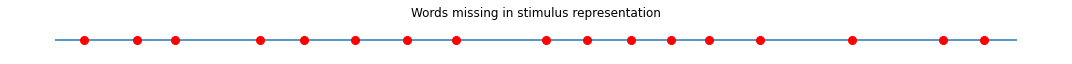

In [193]:
# Not all words in the presentation will be retained in the stimulus: words which
# ended up at the start of an input time series to the model were dropped, because
# the model didn't have those values as targets.
#
# By the above logic, the missing words will likely be distributed roughly evenly
# throughout the stimulus.
words_missing_in_stimulus = set(word_aligned_df.word_idx) - set(story_stim.word_ids.numpy())

plt.figure(figsize=(15, 1))
plt.hlines(0, 0, story_stim.word_ids.max())
plt.plot(list(words_missing_in_stimulus), np.zeros(len(words_missing_in_stimulus)), 'ro', ms=8, mfc='r')
plt.axis('off')
plt.title("Words missing in stimulus representation")
plt.tight_layout()

words_missing_in_stimulus

In [194]:
assert 0 == len(set(story_stim.word_ids.numpy()) - set(word_aligned_df.word_idx)), \
    "Stim words are present which are missing from the aligned data!"

### Align onset data

The design matrix is arranged such that the first word onset is $t=0$. Update the alignment dataframes to reflect this

In [195]:
word_onset_idx = ts_feature_names.index("all_words_onset")
X_onset_times = X[:, word_onset_idx].nonzero()[0] / sfreq
X_onset_times[:10]

array([0.       , 0.140625 , 0.1953125, 0.4375   , 0.6015625, 0.6953125,
       0.8203125, 1.1875   , 1.25     , 1.5390625])

In [196]:
shift = word_aligned_df.onset.min()
word_aligned_df["onset"] -= shift
word_aligned_df["offset"] -= shift
phoneme_aligned_df["onset"] -= shift
phoneme_aligned_df["offset"] -= shift
phoneme_aligned_df["offset_word"] -= shift

# TODO check consistency

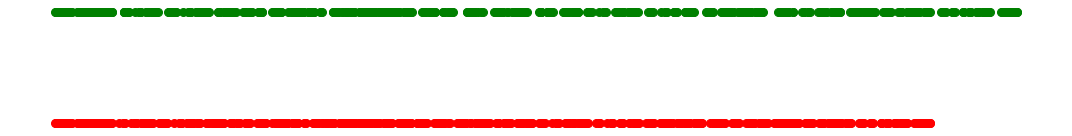

In [197]:
plt.figure(figsize=(15, 2))
plt.hlines(0, 0, X_onset_times.max())
plt.plot(X_onset_times, np.zeros(len(X_onset_times)), 'ro', ms=8, mfc='r')
plt.plot(word_aligned_df.onset.values, np.ones(len(word_aligned_df)), 'go', ms=8)
plt.axis('off')
plt.tight_layout()

In [198]:
# Find overlap
array1 = X_onset_times
array2 = word_aligned_df.onset.unique()
import itertools
from tqdm.auto import trange
matches = []
no_match = []
for i0 in trange(array1.shape[0]):
    for i1 in range(array2.shape[0]):
        if np.isclose(array1[i0], array2[i1], atol=1e-1):
            matches.append((i0, i1))
            break
    else:
        no_match.append(i0)

  0%|          | 0/546 [00:00<?, ?it/s]

In [199]:
len(no_match)

275

In [200]:
len(matches)

271

In [201]:
no_match[:5]

[49, 50, 52, 53, 54]

In [202]:
X_onset_times[40:60]

array([ 9.0546875,  9.1875   ,  9.296875 ,  9.421875 ,  9.828125 ,
        9.9609375, 10.3046875, 10.4296875, 10.515625 , 11.8671875,
       12.59375  , 12.703125 , 12.8984375, 14.       , 14.640625 ,
       14.7421875, 14.90625  , 15.1328125, 15.9609375, 16.0390625])

In [203]:
X_onset_times[no_match[:5]]

array([11.8671875, 12.59375  , 12.8984375, 14.       , 14.640625 ])

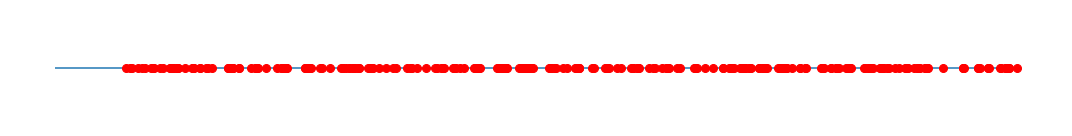

In [204]:
plt.figure(figsize=(15, 2))
plt.hlines(0, 0, X_onset_times.max())
plt.plot(X_onset_times[no_match], np.zeros(len(X_onset_times[no_match])), 'ro', ms=8, mfc='r')
# plt.plot(word_aligned_df.onset.values, np.ones(len(word_aligned_df)), 'go', ms=8)
plt.axis('off')
plt.tight_layout()

## TODO: investigate evident misalignment here

Looks like there's a misalignment that starts with the onset of a new sentence "Santiago" and may trigger a massive misalignment for rest of run.

For now we'll put up with this incongruity in the pipeline.

In [205]:
word_aligned_df.iloc[40:60]

,word_idx,word,onset,offset,token_idx
40,40,AND,9.06,9.19,730
41,41,IT,9.19,9.30,731
42,42,WAS,9.30,9.42,732
43,43,PLEASANT,9.42,9.83,733
44,44,AND,9.83,9.96,734
45,45,SUNNY,9.96,10.31,735
46,46,ON,10.31,10.43,736
47,47,THE,10.43,10.52,737
48,48,TERRACE,10.52,11.02,738
49,48,TERRACE,10.52,11.02,739


In [206]:
len(X_onset_times), len(word_aligned_df)

(546, 567)

## Load signal data

In [207]:
min_time, max_time = 0, len(X) / sfreq
max_time

163.7265625

In [208]:
# Check compatibility with alignment data.
assert min_time <= word_aligned_df.onset.min()
assert min_time <= phoneme_aligned_df.onset.min()

# NB looks like the last sentence-ish of each run is truncated from the signal
# data. TODO double check this with authors?
# assert max_time >= word_aligned_df.offset.max()
# assert max_time >= phoneme_aligned_df.offset.max()
chopped_words = word_aligned_df.offset >= max_time
chopped_phonemes = phoneme_aligned_df.offset >= max_time
print(f"{chopped_words.sum()}, {chopped_phonemes.sum()} chopped words/phonemes. Dropping.")

# word_aligned_df = word_aligned_df[~chopped_words]
# phoneme_aligned_df = phoneme_aligned_df[~chopped_phonemes]

45, 130 chopped words/phonemes. Dropping.


In [209]:
word_aligned_df.tail()

,word_idx,word,onset,offset,token_idx
562,541,AND,178.09,178.18,1364
563,542,YOUR,178.18,178.39,1365
564,543,EYES,178.39,178.60,1366
565,544,ARE,178.60,178.66,1367
566,545,GOOD,178.66,178.99,1368


In [85]:
# We may have residual phonemes without a corresponding word now. Remove those.
orphaned_phonemes = ~phoneme_aligned_df.word_idx.isin(word_aligned_df.word_idx)
if orphaned_phonemes.any():
    print(f"Also dropping {orphaned_phonemes.sum()} orphaned phonemes.")
    phoneme_aligned_df = phoneme_aligned_df[~orphaned_phonemes]

Also dropping 1 orphaned phonemes.


In [88]:
# Check consistency.
assert set(word_aligned_df.word_idx) == set(phoneme_aligned_df.word_idx)

## Produce BerpDataset representations

In [91]:
# Now produce onset information from canonical aligned data.
# NB this will contain NaNs if there was misalignment above.
word_onsets = word_aligned_df.groupby("word_idx").onset.min().to_dict()
word_onsets = torch.tensor([word_onsets.get(word_id.item(), np.nan)
                            for word_id in story_stim.word_ids])

word_offsets = word_aligned_df.groupby("word_idx").offset.max().to_dict()
word_offsets = torch.tensor([word_offsets.get(word_id.item(), np.nan)
                             for word_id in story_stim.word_ids])

In [95]:
# Compute phoneme onsets relative to word onset.
phoneme_onsets = phoneme_aligned_df.groupby("word_idx") \
    .apply(lambda xs: list(xs.onset - xs.onset.min())).to_dict()
phoneme_onsets = [torch.tensor(phoneme_onsets.get(word_id.item(), [np.nan]))
                  for word_id in story_stim.word_ids]

In [97]:
max_num_phonemes = max(len(onsets) for onsets in phoneme_onsets)
# Sanity check: max_num_phonemes as computed from aligned data should
# match that produced earlier by the natural language stimulus processor
assert max_num_phonemes == story_stim.max_n_phonemes, \
    "%d %d" % (max_num_phonemes, story_stim.max_n_phonemes)

In [98]:
# Pad phoneme onset information
phoneme_onsets = torch.stack([
    pad(onsets, (0, max_num_phonemes - len(onsets)), value=0.)
    if len(onsets) < max_num_phonemes
    else onsets
    for onsets in phoneme_onsets
])

In [105]:
dataset = BerpDataset(
    name=f"{story_name}/sub{subject}/run{run}",
    stimulus_name=story_stim.name,
    sample_rate=sfreq,
    
    phonemes=story_stim.phonemes,
    
    word_onsets=word_onsets,
    word_offsets=word_offsets,
    phoneme_onsets=phoneme_onsets,
    
    X_ts=X,
    ts_feature_names=ts_feature_names,
    
    X_variable=X_variable,
    variable_feature_names=variable_feature_names,
    
    Y=y,
    sensor_names=sensor_names,
)

In [106]:
with Path(output_path).open("wb") as f:
    pickle.dump(dataset, f)